In [1]:
from resources.notebook_library import *
from resources.gate_simulation import ghz_simulation
from resources.gate_simulation import gate_simulation_functions
GateSimulation  = reload(ghz_simulation)
sim = GateSimulation.Simulation('O-x-O')

Initializing system O-x-O ...
Constructing states and excitations ...
Constructing ground and first-excited statespace ...
Constructing gs_hamiltonian ...
Constructing e1_hamiltonian ...
Constructing interactions V_plus and V_minus ...
Constructing NJ_hamiltonian ...
Inverting NJ_hamiltonian ...


Error in atexit._run_exitfuncs:
Traceback (most recent call last):
  File "/usr/lib/python3/dist-packages/IPython/core/history.py", line 576, in end_session
    self.db.execute("""UPDATE sessions SET end=?, num_cmds=? WHERE
sqlite3.OperationalError: disk I/O error


Constructing eff_hamiltonian and effective lindblad operators ...

System  O-x-O  initialized in 29.5 seconds.
Preparing Analytical sub-class

Done!


# Obtain grid(s) of performance

In [20]:
# Global Parameters 
kSweep = [0.99]   #[0.995]

print(kSweep[0]/ (4-4*kSweep[0]))
CSweep = [25]#[24.75,25]#[10,15]#,20,25]     #[20,25,30]
SplitSweep = [7]#[7,8,9,10]#[3,5,10]  #[3,5,10]

# Dimensions of first grid for optimization  --- Give odd numbers
DeNum = 3
DENum = 11
tgNum = 3
rotNum = 3  

# Limits of the grid
## DE will be multiplied by  np.sqrt(C_val)/gamma_val
DE_min = 0.05 
DE_max = 2
tg_min = 0.8
tg_max = 1.2
rot_min = 0.90
rot_max = 1.11

24.74999999999998


## Using analytical simulations

In [3]:
gamma_val = sim.parameters[sg.var('gamma')]

SplitSweep = [spl*gamma_val for spl in SplitSweep] # for gamma_val = 1 it is not necessary

AllParams = [(a,b,c) for a in kSweep for b in CSweep for c in SplitSweep] # Create a 3-d grid for hardware parameters

TotalParamElems = NumElemsInList(AllParams)
CurrentNumberOfSimulations = 1
for (k, C_val , max_split) in AllParams:
    print(f'Simulating {CurrentNumberOfSimulations} out of {TotalParamElems}')
    CurrentNumberOfSimulations +=1
    
    c_val = k/ (4-4*k)
    # Optimization Parameters  --- Give odd numbers
    # De
    DeSweep = np.linspace(0,max_split , num = DeNum)
    # DE
    DESweep = np.linspace(DE_min , DE_max , num = DENum) * np.sqrt(C_val)/gamma_val
    # GateTime
    tgSweep = np.linspace(tg_min,tg_max , num = tgNum)
    # Rotations
    r1Sweep = np.linspace(rot_min,rot_max , num = rotNum)
    r2Sweep = np.linspace(rot_min,rot_max , num = rotNum)
    r3Sweep = np.linspace(rot_min,rot_max , num = rotNum)
    r4Sweep = np.linspace(rot_min,rot_max , num = rotNum)


    ParamsSweep = [DeSweep ,DESweep,tgSweep,r1Sweep,r2Sweep,r3Sweep,r4Sweep ]
    ResultsShape = tuple([np.shape(param)[0] for param in ParamsSweep])

    Psucc = np.zeros(ResultsShape)
    Fidelity =  np.zeros(ResultsShape)
    GateTime =  np.zeros(ResultsShape)

    sim.Analytical.obtain_gate_performance_hardware(C_val,c_val,max_split)


    def simulation_process(De_val,DE_val,tg_ratio,r1_ratio,r2_ratio,r3_ratio,r4_ratio ):  
        
        param_vals = De_val,DE_val,tg_ratio,r1_ratio,r2_ratio,r3_ratio,r4_ratio  
        index = tuple((np.where(ParamsSweep[i]==param_vals[i] ) for i in range(len(ParamsSweep)) ))
        
        
        tunable_parameter_dictionary = {sg.var('De') : De_val , sg.var('DE') : DE_val 
                        , sg.var('tgr'): tg_ratio
                        , sg.var('r1_r'):r1_ratio, sg.var('r2_r'):r2_ratio,
                          sg.var('r3_r'):r3_ratio,sg.var('r4_r'):r4_ratio}
        gate_time , p_success , fidelity = sim.Analytical.tunable_performance(tunable_parameter_dictionary)

        return gate_time , p_success , fidelity , index

    
    all_sweeps = product(DeSweep,DESweep,tgSweep,r1Sweep,r2Sweep,r3Sweep,r4Sweep)
    len_all_sweeps = DeNum*DENum*tgNum*rotNum**4
    with mp.Pool() as pool:
        for (tg, ps,fid, index) in  tqdm.tqdm(pool.istarmap(simulation_process, all_sweeps),total=len_all_sweeps):
            GateTime[index] = tg
            Psucc[index] = ps
            Fidelity[index] = fid
   
 
    Directory = f'OptimizationResults/Analytical/ResC{C_val}_k{k}_Spl{max_split}_e{DeNum}_E{DENum}_t{tgNum}_r{rotNum}'
    if not os.path.exists(Directory):
        os.makedirs(Directory)
    np.save(Directory+f'/Fidelity',Fidelity)
    np.save(Directory+f'/GateTime',GateTime)
    np.save(Directory+f'/Psucc',Psucc)
    clear_output(wait=True)
    

Simulating 1 out of 1


100%|██████████| 8019/8019 [00:14<00:00, 565.73it/s]


# Plot result

<>:51: DeprecationWarning: invalid escape sequence \%
<>:52: DeprecationWarning: invalid escape sequence \%
<>:67: DeprecationWarning: invalid escape sequence \L
<>:51: DeprecationWarning: invalid escape sequence \%
<>:52: DeprecationWarning: invalid escape sequence \%
<>:67: DeprecationWarning: invalid escape sequence \L
<ipython-input-4-5377845e2951>:51: DeprecationWarning: invalid escape sequence \%
  AllLabels[i][j] += '$F='+ str(np.round(fidelity*100,decimals=2))+'\%$\n'
<ipython-input-4-5377845e2951>:52: DeprecationWarning: invalid escape sequence \%
  AllLabels[i][j] += '$P_{succ}='+ str(np.round(p_success*100,decimals=2))+'\%$\n'
<ipython-input-4-5377845e2951>:67: DeprecationWarning: invalid escape sequence \L
  ax.set_title(f'Gate Performance vs Cooperativity & Detuning Split \nfor $k={kPlot} \Leftrightarrow c = {np.round(cPlot,decimals=1)}$\n'


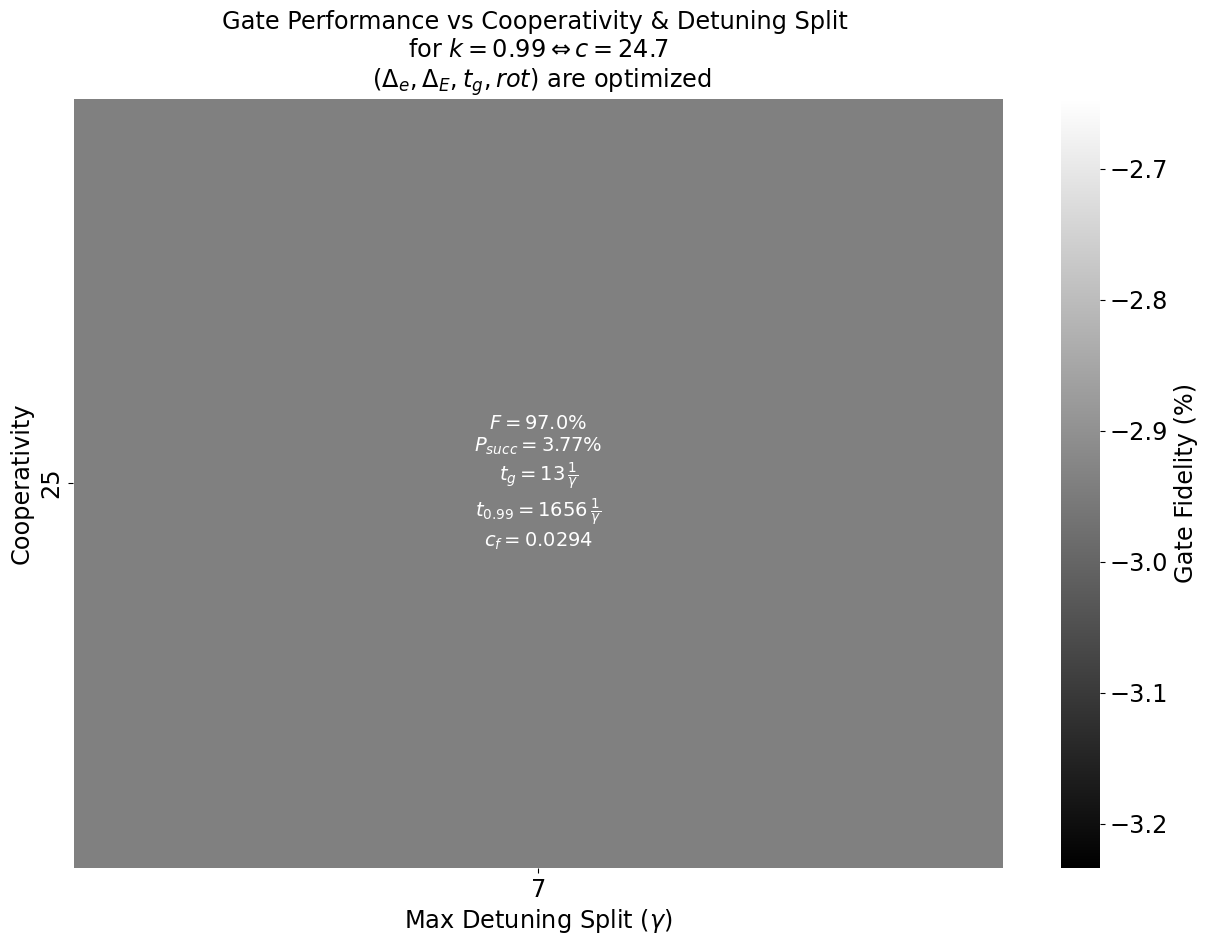

In [4]:
Analytical = True
kPlot = kSweep[0]
cPlot = kPlot / (4-4*kPlot)

fidelity_cap = 0.97
interval_of_confidence = 0.99


if Analytical:
    subdir = 'Analytical'
else:
    subdir = 'Superoperator'
AllLabels = [["" for i in range(len(SplitSweep))]for j in range(len(CSweep))]
FidelityPlot = np.zeros(np.array(AllLabels).shape)
for (i,c) in enumerate(CSweep):
    for (j,spl) in enumerate(SplitSweep):
        DataDirectory = f'OptimizationResults/Analytical/ResC{c}_k{kPlot}_Spl{spl}_e{DeNum}_E{DENum}_t{tgNum}_r{rotNum}/'
        GateTimeData = np.load(DataDirectory+"GateTime.npy")
        FidelityData = np.load(DataDirectory+"Fidelity.npy")
        PsuccData = np.load(DataDirectory+"Psucc.npy")
        #ConcurrenceData = np.load(DataDirectory+"Concurrence.npy")


        argm = ArgMin( gate_simulation_functions.gate_performance_cost_function(FidelityData,PsuccData,GateTimeData,fidelity_cap,interval_of_confidence) ) 
        #argm = ArgMin(1-FidelityData)
        
        #fidelity , p_success, gate_time = FidelityData[argm] , PsuccData[argm], GateTimeData[argm]


        init_params = [ParamsSweep[i][argm[i]] for i in range(len(ParamsSweep))]

        parameters_to_optimize = [ sg.var('De'),  sg.var('DE'), sg.var('tgr') , sg.var('r1_r') , sg.var('r2_r'), sg.var('r3_r'), sg.var('r4_r') ]
        init_dict = {parameters_to_optimize[i] :ParamsSweep[i][argm[i]] for i in range(len(ParamsSweep))}
        
        sim.Analytical.optimize_gate_performance_hardware(init_dict,fidelity_cap,interval_of_confidence)
        opt_tg = sim.Analytical.optimized_performance['gate_time']
        opt_fid = sim.Analytical.optimized_performance['fidelity']
        opt_p_success = sim.Analytical.optimized_performance['p_success']
        fidelity , p_success, gate_time = opt_fid , opt_p_success , opt_tg
        
        t_conf = gate_simulation_functions.interval_of_confidence_geometric(interval_of_confidence,p_success) * gate_time

        min_cost_function = gate_simulation_functions.gate_performance_cost_function(fidelity,p_success,gate_time,fidelity_cap,interval_of_confidence)
        
        
        FidelityPlot[i][j] = -min_cost_function#FidelityData[argm]
        
        
        

        AllLabels[i][j] += '$F='+ str(np.round(fidelity*100,decimals=2))+'\%$\n'
        AllLabels[i][j] += '$P_{succ}='+ str(np.round(p_success*100,decimals=2))+'\%$\n'
        AllLabels[i][j] += '$t_g='+ str(int(gate_time))+r' \,\frac{1}{\gamma}$'
        AllLabels[i][j] += '\n$t_{'+str(np.round(interval_of_confidence,decimals=2)) +'} = '+ str(int(t_conf))+r' \,\frac{1}{\gamma}$'
        AllLabels[i][j] += '\n$c_f='+ str( np.round( min_cost_function,decimals= 5))+'$'
        #AllLabels[i][j] += f'\n Max at\n{argm}'
        


fig, ax = plt.subplots()


ax = sns.heatmap(FidelityPlot*100,yticklabels=CSweep,xticklabels=SplitSweep,cmap='gray', linewidth=0.5,annot=AllLabels, fmt = ''\
    ,cbar_kws={'label': 'Gate Fidelity (%)'}, annot_kws={"size": 14}) #Greys
ax.set_ylabel('Cooperativity')
ax.set_xlabel(r'Max Detuning Split $(\gamma)$')
ax.set_title(f'Gate Performance vs Cooperativity & Detuning Split \nfor $k={kPlot} \Leftrightarrow c = {np.round(cPlot,decimals=1)}$\n'
+r' $(\Delta_e,\Delta_E,t_g,rot)$ are optimized')
plt.show() 
figure = ax.get_figure()
figure.savefig(f'plots/OptimizedHeatmap.svg',transparent=False)

In [5]:
parameters_to_optimize = [ sg.var('De'),  sg.var('DE'), sg.var('tgr') , sg.var('r1_r') , sg.var('r2_r'), sg.var('r3_r'), sg.var('r4_r') ]
num_parameters = len(parameters_to_optimize)




def cost_function(params):
    '''
    Function that is used for minimization. Essentially it only makes use of global gate performance function.
    '''
    De_val, DE_val, tg_ratio , r1_ratio , r2_ratio, r3_ratio, r4_ratio = params
    
    tunable_parameters_dict = {sg.var('De') : De_val , sg.var('DE') : DE_val 
            , sg.var('tgr'): tg_ratio
            , sg.var('r1_r'):r1_ratio, sg.var('r2_r'):r2_ratio,
                sg.var('r3_r'):r3_ratio,sg.var('r4_r'):r4_ratio}
    gate_time, p_success, fidelity_3ghz = sim.Analytical.tunable_performance(tunable_parameters_dict)
    
    return gate_simulation_functions.gate_performance_cost_function(fidelity_3ghz,p_success,gate_time, fidelity_cap, interval_of_confidence)


import scipy.optimize
def callback(x,*args,**kargs):
    print(cost_function(x))



In [6]:


parameters_to_optimize = [ sg.var('De'),  sg.var('DE'), sg.var('tgr') , sg.var('r1_r') , sg.var('r2_r'), sg.var('r3_r'), sg.var('r4_r') ]

In [21]:
bounds = [[0 , max_split] , [0,DE_max] , [tg_min,tg_max]  ]
for i in range(4): bounds.append([rot_min,rot_max]) 

In [22]:
bounds

[[0, 7],
 [0, 2],
 [0.8, 1.2],
 [0.9, 1.11],
 [0.9, 1.11],
 [0.9, 1.11],
 [0.9, 1.11]]

In [23]:
scipy.optimize.differential_evolution(cost_function,bounds=bounds, workers=16,disp=True)

differential_evolution step 1: f(x)= 0.041617
differential_evolution step 2: f(x)= 0.041617
differential_evolution step 3: f(x)= 0.0323333
differential_evolution step 4: f(x)= 0.0298188
differential_evolution step 5: f(x)= 0.0297851
differential_evolution step 6: f(x)= 0.0297834
differential_evolution step 7: f(x)= 0.0296644
differential_evolution step 8: f(x)= 0.0296037
differential_evolution step 9: f(x)= 0.0295074
differential_evolution step 10: f(x)= 0.0295074
differential_evolution step 11: f(x)= 0.0295074
differential_evolution step 12: f(x)= 0.0295074
differential_evolution step 13: f(x)= 0.0294657
differential_evolution step 14: f(x)= 0.0293773
differential_evolution step 15: f(x)= 0.0293755
differential_evolution step 16: f(x)= 0.0293755
differential_evolution step 17: f(x)= 0.0293755
differential_evolution step 18: f(x)= 0.0293288
differential_evolution step 19: f(x)= 0.0293082
differential_evolution step 20: f(x)= 0.0293082
differential_evolution step 21: f(x)= 0.0293068
dif

     fun: 0.029211848710421623
 message: 'Optimization terminated successfully.'
    nfev: 5223
     nit: 46
 success: True
       x: array([0.38130563, 1.50587033, 0.88118476, 1.07076419, 1.05961752,
       1.046447  , 1.06560916])

In [24]:
x = [0.38130563, 1.50587033, 0.88118476, 1.07076419, 1.05961752,
       1.046447  , 1.06560916]
dix = {parameters_to_optimize[i]:x[i] for i in range(len(x))}
sim.Analytical.tunable_performance(dix)

(13.497786592288726, 0.0478472765387253, 0.9701241190817942)

In [25]:
p_success = 0.0478472765387253
gate_time = 13.497786592288726

In [26]:
gate_simulation_functions.interval_of_confidence_geometric(interval_of_confidence,p_success) * gate_time

1268.7919396751402

In [11]:
scipy.optimize.dual_annealing(func,bounds=bounds,callback=callback)

NameError: name 'func' is not defined

Tuple(([0, 10], [0.05, 2], [0.9, 1.1], [0.95, 1.05], [0.95, 1.05], [0.95, 1.05], [0.95, 1.05])):(([0, 10], [0.05, 2], [0.9, 1.1], [0.95, 1.05], [0.95, 1.05], [0.95, 1.05], [0.95, 1.05]),)